In [1]:
# conda activate chronocell

import os
import sys
import numpy as np
import anndata as ad

sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")

import Chronocell
print(Chronocell.__version__)

from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS
from Chronocell.utils import *
from Chronocell.plotting import *
from Chronocell.models.two_species_ss import get_Y

2024.10


In [2]:
# Ref: https://www.nature.com/articles/nature10098#Fig2

In [3]:
# Splicing rate
beta_mu = 2
beta_sd = 0.5

# Transcription rate
alpha_mu = np.log(2)
alpha_sd = 1

# Translation rate
transl_rate_mu = np.log(100)
transl_rate_sd = 1

# mRNA degradation rate
rna_median_half_life = 9
gamma_rate = np.log(2) / rna_median_half_life
gamma_mu = np.log(gamma_rate) # Median of lognormal
gamma_sd = 0.5

# Protein degradation rate
protein_median_half_life = 12
deg_rate = np.log(2) / protein_median_half_life
deg_rate_mu = np.log(deg_rate) # Median of lognormal
deg_rate_sd = 1.5

In [128]:
# Simulate data

np.random.seed(12)

n = 1000 # No. cells per lineage
p = 100 # No. genes
m = 101 # No. time steps

topo = np.array([0, 1, 2, 3])
tau = (0, 1, 2, 3)
n_states = len(set(topo.flatten()))

# Make all parameters constant except variable_param
variable_param = 'gamma'

theta = np.zeros((p, n_states + 2))
phi = np.zeros((p, 2))

theta[:,:n_states] = np.tile(np.random.lognormal(alpha_mu, alpha_sd, size=(1, n_states)), (p, 1))
theta[:,-2] = np.random.lognormal(beta_mu, beta_sd) 
theta[:,-1] = np.random.lognormal(gamma_mu, gamma_sd)
theta[:,0] /= theta[:, -2]

phi[:,0] = np.random.lognormal(transl_rate_mu, transl_rate_sd) 
phi[:,-1] = np.random.lognormal(deg_rate_mu, deg_rate_sd)

if variable_param == "alpha":
    theta[:,:n_states] = np.random.lognormal(alpha_mu, alpha_sd, size=(p, n_states))
elif variable_param == "beta":
    theta[:,-2] = np.random.lognormal(beta_mu, beta_sd, size=p)
elif variable_param == "gamma":
    theta[:,-1] = np.random.lognormal(gamma_mu, gamma_sd, size=p)
elif variable_param == "transl_rate":
    phi[:,0] = np.random.lognormal(transl_rate_mu, transl_rate_sd, size=p)
else: # variable_param == "deg_rate"
    phi[:,-1] = np.random.lognormal(deg_rate_mu, deg_rate_sd, size=p)

# Simulate RNA counts

Y = np.zeros((n*L, p, 2))
t = np.sort(np.random.uniform(tau[0], tau[-1], size=n))
Y = get_Y(theta, t, tau) # Cells x genes x RNA species

In [132]:
theta[:, -1]

array([0.0514457 , 0.32373571, 0.05711726, 0.09753841, 0.13321919,
       0.04194811, 0.15068566, 0.07245335, 0.12777559, 0.04876843,
       0.04602813, 0.14102201, 0.09898358, 0.08255303, 0.10610173,
       0.10025171, 0.0432431 , 0.02546617, 0.03321958, 0.03149947,
       0.02540003, 0.05571795, 0.05913457, 0.07552118, 0.08575597,
       0.06355072, 0.06783415, 0.07988945, 0.04677813, 0.0538978 ,
       0.07839232, 0.0548743 , 0.05786295, 0.0730458 , 0.15019485,
       0.09031923, 0.06505416, 0.05747693, 0.07271574, 0.23625853,
       0.01596357, 0.10064362, 0.08651026, 0.11884543, 0.04337622,
       0.22167002, 0.12703837, 0.07506169, 0.08342196, 0.05383296,
       0.07898668, 0.07168984, 0.12344621, 0.09209677, 0.07386899,
       0.10808531, 0.1017021 , 0.08608864, 0.03585651, 0.12884671,
       0.0429866 , 0.04648999, 0.07306751, 0.09948719, 0.15569231,
       0.03312107, 0.16071535, 0.17455663, 0.06114942, 0.06963983,
       0.05786481, 0.05696108, 0.03942197, 0.03308868, 0.06971

In [ ]:

# Simulate protein counts

p = len(phi)

y0 = Y[0, :, 1] # Steady-state spliced RNA levels (RNA levels at state 0 at t0
p0 = phi[:,0] * y0

# Protein production paramters:
transl_rate = phi[:,0].T
deg_rate = phi[:,-1].reshape((1, -1))

P = np.zeros((n, p))

t_l = t.reshape((-1, 1)) # Time points/cells in lineage l     
y_l = Y[:, :, 1] # Counts from cells in lineage l

t_diff = t_l - t_l.T 
# t_diff: rows = target time, columns = past times, e.g. t_diff[m, i] = time difference between t_m and t_i 

t_diff[t_diff < 0] = 0 
# Time contributions can't be negative

decay_matrix = np.exp(-t_diff[:, :, None] * deg_rate) 
# E.g. decay_matrix[m, i, p] = decay factor for protein abundance at t_m from RNA available at t_i (for gene p)

p_l = p0 * np.exp(-deg_rate * t_l) 
# Pre-existing protein that has not yet degraded

protein_contrib = np.einsum('mip, ip -> mp', decay_matrix, y_l) # Integrate RNA counts still surviving up to each time point
p_l += transl_rate * protein_contrib # Newly synthesized protein

P = p_l

In [191]:
np.corrcoef(y_l[0, :], theta[:, -1])

array([[ 1.        , -0.73461987],
       [-0.73461987,  1.        ]])

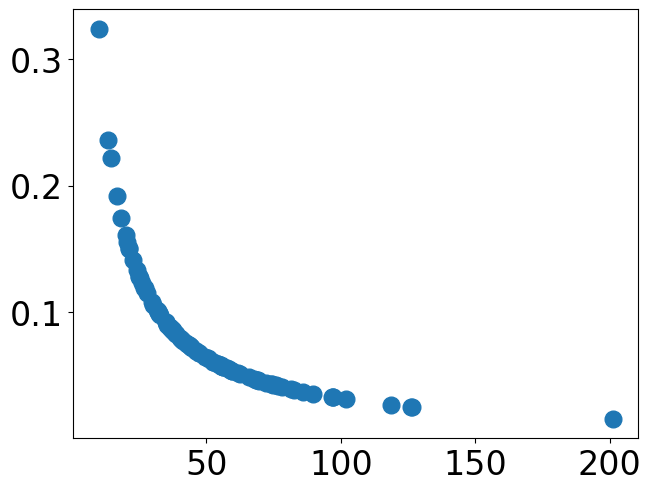

In [194]:
plt.scatter(y_l[0, :], theta[:, -1])

In [180]:
y_l[:, 0]

array([62.3873558 , 62.38922962, 62.38964625, 62.39378841, 62.39510012,
       62.3956425 , 62.40205122, 62.40504233, 62.40544301, 62.42346278,
       62.44504382, 62.44921464, 62.45234122, 62.49656178, 62.55613518,
       62.58465612, 62.58899113, 62.58928605, 62.59101079, 62.59138706,
       62.60084079, 62.65296633, 62.66648663, 62.67016318, 62.68618482,
       62.68900633, 62.74580364, 62.75706741, 62.77401796, 62.77410821,
       62.7798129 , 62.7823507 , 62.81998088, 62.85255912, 62.87133375,
       62.91506256, 62.96554566, 62.9687504 , 62.97589393, 62.98578324,
       63.01121775, 63.02772932, 63.03585315, 63.07482946, 63.07511302,
       63.09377495, 63.09488197, 63.11272351, 63.12323335, 63.16253711,
       63.20710013, 63.20741786, 63.24054952, 63.25149126, 63.2697102 ,
       63.42019364, 63.42059863, 63.4423298 , 63.44510729, 63.45022748,
       63.47121328, 63.52957248, 63.53401777, 63.53562517, 63.53785857,
       63.58481769, 63.6266353 , 63.66046384, 63.66471441, 63.67

In [176]:
decay_matrix[:, :, 0]

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99972937, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99969481, 0.99996542, 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.86543548, 0.86566976, 0.86569969, ..., 1.        , 1.        ,
        1.        ],
       [0.86543068, 0.86566495, 0.86569489, ..., 0.99999445, 1.        ,
        1.        ],
       [0.86537685, 0.86561111, 0.86564104, ..., 0.99993225, 0.9999378 ,
        1.        ]])

In [164]:
np.corrcoef(P[:, 0], Y[:, 0, 1])

array([[ 1.       , -0.9047517],
       [-0.9047517,  1.       ]])

In [123]:
import pandas as pd

data = pd.DataFrame(columns=['Cor', 'Alpha', 'Beta', 'Gamma', 'Translation_rate', 'Degradation_rate', 'RNA_half_life', 'Protein_half_life'])

for i in range(p):
    
    cor = np.corrcoef(Y[:, i, 1], P[:, i])[0, 1] # Correlation between RNA and protein abundance for gene i
    alpha_mean = np.mean(theta[i, 0:(K+1)]) # Mean transcription rate
    beta = theta[i, -2] # Splicing rate 
    gamma = theta[i, -1] # RNA degradation rate
    transl_rate = phi[i, 0] # Translation rate
    deg_rate = phi[i, -1] # Protein degradation rate
    r_half = np.log(2) / gamma
    p_half = np.log(2) / deg_rate
    
    data.loc[len(data)] = [cor, alpha_mean, beta, gamma, transl_rate, deg_rate, r_half, p_half]


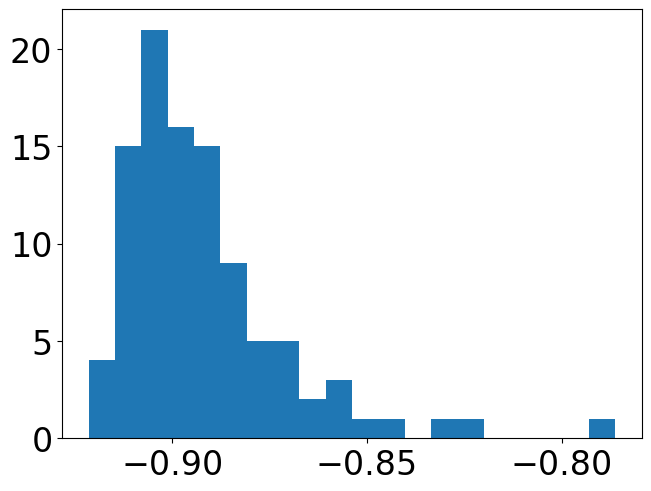

In [124]:
# Correlation between RNA and protein abundance per gene
plt.hist(data['Cor'], bins=20);

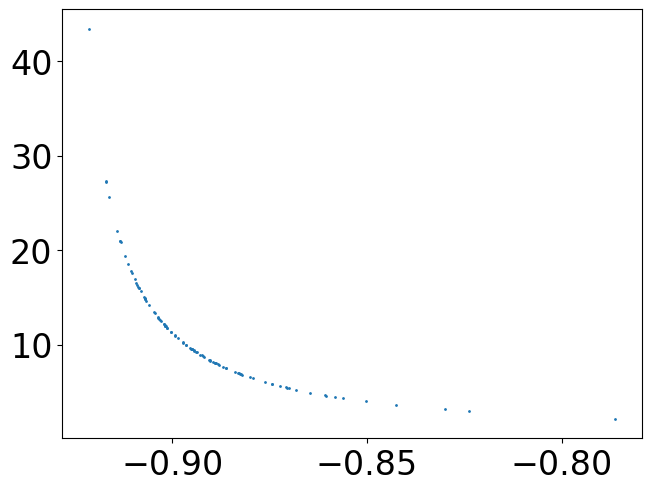

In [125]:
data = data.sort_values(by="RNA_half_life", ascending=False)
plt.scatter(data['Cor'], data['RNA_half_life'], s=1);

In [127]:
data.head()

,Cor,Alpha,Beta,Gamma,Translation_rate,Degradation_rate,RNA_half_life,Protein_half_life
40,-0.921474,1.055916,10.767921,0.015964,100.514024,0.048231,43.420550,14.371515
20,-0.916964,1.055916,10.767921,0.025400,100.514024,0.048231,27.289228,14.371515
17,-0.916932,1.055916,10.767921,0.025466,100.514024,0.048231,27.218348,14.371515
78,-0.916174,1.055916,10.767921,0.027063,100.514024,0.048231,25.612235,14.371515
19,-0.914074,1.055916,10.767921,0.031499,100.514024,0.048231,22.005044,14.371515


In [126]:
data.tail()

,Cor,Alpha,Beta,Gamma,Translation_rate,Degradation_rate,RNA_half_life,Protein_half_life
67,-0.850154,1.055916,10.767921,0.174557,100.514024,0.048231,3.970901,14.371515
76,-0.842569,1.055916,10.767921,0.192179,100.514024,0.048231,3.606776,14.371515
45,-0.829923,1.055916,10.767921,0.221670,100.514024,0.048231,3.126932,14.371515
39,-0.823681,1.055916,10.767921,0.236259,100.514024,0.048231,2.933850,14.371515
1,-0.786220,1.055916,10.767921,0.323736,100.514024,0.048231,2.141090,14.371515


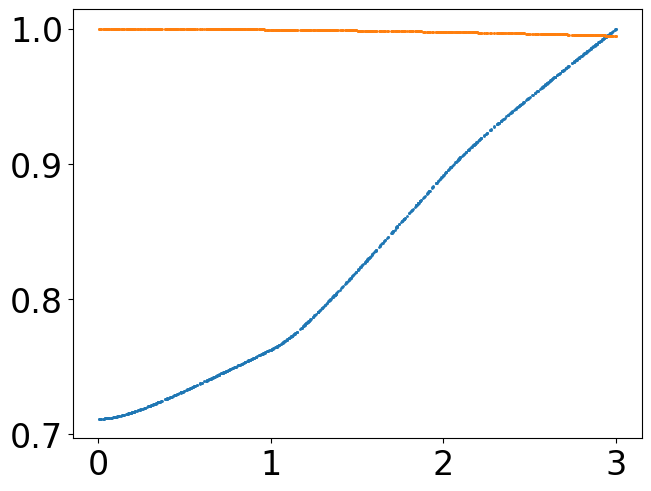

In [113]:
i = data.loc[data['Cor'] < 0].index[idx]
y_i = Y[:, i, 1]/max(Y[:, i, 1])
p_i = P[:, i]/max(P[:, i])
plt.scatter(t, y_i, s=1)
plt.scatter(t, p_i, s=1)